In [198]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from pprint import pprint

<AxesSubplot: title={'center': 'Execution'}, xlabel='timestamp', ylabel='BPs'>

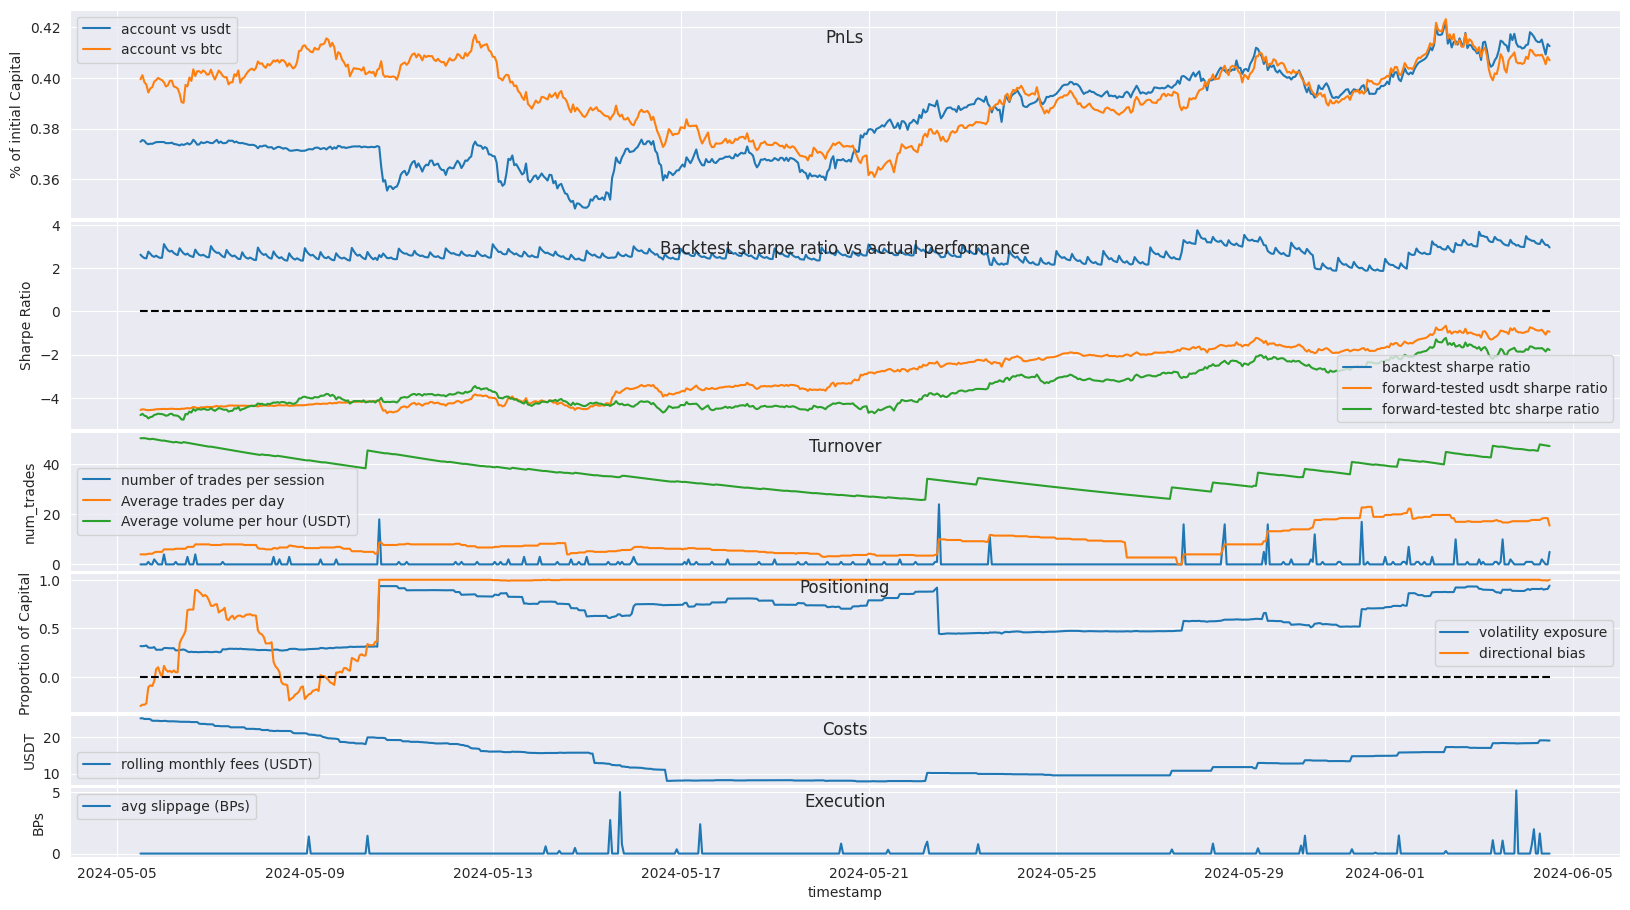

In [209]:
with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/trades.json"), 'r') as file:
    trades = json.load(file)
    
trade_df = pl.from_dicts(trades)

trade_df = trade_df.with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('executed_quote_size').cast(pl.Float32),
)

trades_1h = (
    trade_df
    .sort('timestamp')
    .group_by_dynamic(pl.col('timestamp'), every='1h')
    .agg(
            pl.sum('executed_quote_size'),
            pl.sum('usdt_fees'),
            pl.mean('price_impact'),
        )
    .upsample(time_column='timestamp', every='1h')
    .fill_null(0.0)
)

start = trades_1h.item(0, 'timestamp')
trades_1h = pl.DataFrame(
    {
        "timestamp": pl.datetime_range(
            start=start,
            end=datetime.now(tz=timezone.utc),
            interval="1h",
            time_unit='ms',
            eager=True,
        )
    }
).lazy().join(trades_1h.lazy(), on="timestamp", how="left").fill_null(0).collect()

# TODO i want drawdown statistics like max dd, avg dd, max dd duration and avg dd duration and current dd duration - for the backtest and the live trading so i can compare
# TODO i want a breakdown for each coin that shows how much total pnl i have made (accounting for fees), total volume traded, avg pct profit per unit volume etc
# TODO i want some stats like avg pnl per day on a monthly rolling basis, total pnl since records began, and more
# TODO i want to redo the main pnl chart so i take the diff of the account balance series, then add/subtract any transfers in/out of the margin account, then turn it back into a cummulative series for displaying on the chart. that way, the pnl chart won't be affected by profit-taking or adding capital in.

with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)

for s in session_records:
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0
    elif s.get('volatility_exposure') > 10:
        s['volatility_exposure'] = 0.9349222790015471

session_records_2 = [s for s in session_records if s.get('bt_sharpe')]
session_records_3 = [s for s in session_records if s.get('volatility_exposure')]

sr = pl.from_dicts(session_records).select(['timestamp', 'usdt_net', 'btc_net', 'trades'])



sr_2 = pl.from_dicts(session_records_2)['bt_sharpe']
sr_3 = pl.from_dicts(session_records_3)['volatility_exposure']

allos = [s[f"{s.get('port_weights', 'flat')}_allocations"] for s in session_records]
abs_allos = [{k: abs(v) for k, v in i.items()} for i in allos]
bias_num = [sum(z.values()) for z in allos]
bias_denom = [sum(z.values()) for z in abs_allos]
bias = pl.Series([x/y for x, y in zip(bias_num, bias_denom)])

pred_exp = pl.Series([sum([abs(v) for v in z.values()]) for z in allos]) * 2

sr_2 = pl.Series([0.0] * (len(sr) - len(sr_2))).extend(sr_2)
sr_3 = pl.Series([0.0] * (len(sr) - len(sr_3))).extend(sr_3)

trades_1h = trades_1h.tail(len(sr))

sharpe_lb = 1440# 168 = 1 week, 720 = 30 days, 2190 = 1Q, 8760 = 1 year
sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('usdt_net').truediv(sr.item(0, 'usdt_net')).alias('usdt_pnl_pct'),
    pl.col('btc_net').truediv(sr.item(0, 'btc_net')).alias('btc_pnl_pct'),
    pl.col('usdt_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('usdt_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('usdt_sharpe'),
    pl.col('btc_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('btc_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('btc_sharpe'),
    pl.lit(1.0).sub(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('usdt_net')).truediv(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1))).alias('usdt_dd'),
    pl.lit(1.0).sub(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('btc_net')).truediv(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1))).alias('btc_dd'),
    pl.col('trades').alias('num_trades'),
    pl.col('trades').rolling_sum(96).truediv(4).alias('avg_trades'),
    trades_1h['executed_quote_size'].ewm_mean(span=720).alias('avg_hourly_volume'),
    trades_1h['usdt_fees'].rolling_sum(720, min_periods=2).alias('rolling_monthly_fees'),
    trades_1h['price_impact'].alias('avg_slippage'),
    sr_2.alias('bt_sharpe'),
    sr_3.alias('volatility_exposure'),
    bias.alias('bias'),
    pl.col('usdt_net').diff(24).ewm_mean(span=720).alias('avg_daily_pnl_usdt'),
    pl.col('btc_net').diff(24).ewm_mean(span=720).alias('avg_daily_pnl_btc'),
    # pred_exp.alias('pred_exp')
).tail(720)

fig, ax = plt.subplots(nrows=6, figsize=(20, 11), gridspec_kw=dict(height_ratios=[3, 3, 2, 2, 1, 1]), sharex=True)
fig.subplots_adjust(hspace = 0.02)
ax[0].set_ylabel(ylabel='% of initial Capital')
ax[1].set_ylabel(ylabel='Sharpe Ratio')
ax[2].set_ylabel(ylabel=None)
ax[3].set_ylabel(ylabel='Proportion of Capital')
ax[4].set_ylabel(ylabel='USDT')
ax[5].set_ylabel(ylabel='BPs')
ax[0].set_title('PnLs', y=0.8)
ax[1].set_title('Backtest sharpe ratio vs actual performance', y=0.8)
ax[2].set_title('Turnover', y=0.8)
ax[3].set_title('Positioning', y=0.8)
ax[4].set_title('Costs', y=0.6)
ax[5].set_title('Execution', y=0.6)

sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc', ax=ax[0])
# sns.lineplot(data=sr, x='timestamp', y='usdt_dd', label='drawdown vs usdt', ax=ax[0])
# sns.lineplot(data=sr, x='timestamp', y='btc_dd', label='drawdown vs btc', ax=ax[0])

sns.lineplot(data=sr, x='timestamp', y='bt_sharpe', label='backtest sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='usdt_sharpe', label='forward-tested usdt sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='btc_sharpe', label='forward-tested btc sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[1])

sns.lineplot(data=sr, x='timestamp', y='num_trades', label='number of trades per session', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='avg_trades', label='Average trades per day', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='avg_hourly_volume', label='Average volume per hour (USDT)', ax=ax[2])

sns.lineplot(data=sr, x='timestamp', y='volatility_exposure', label='volatility exposure', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='bias', label='directional bias', ax=ax[3])
# sns.lineplot(data=sr, x='timestamp', y='pred_exp', label='predicted exposure', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[3])

sns.lineplot(data=sr, x='timestamp', y='rolling_monthly_fees', label='rolling monthly fees (USDT)', ax=ax[4])
sns.lineplot(x=sr['timestamp'], y=sr['avg_slippage']*10_000, label='avg slippage (BPs)', ax=ax[5])

# statistics


In [200]:
from binance.client import Client as Client_b
import mt.resources.keys as keys
client = Client_b(keys.bPkey, keys.bSkey)
m_acct = client.get_margin_account()

In [75]:
m_acct.keys()

dict_keys(['tradeEnabled', 'transferEnabled', 'borrowEnabled', 'marginLevel', 'totalAssetOfBtc', 'totalLiabilityOfBtc', 'totalNetAssetOfBtc', 'userAssets', 'collateralMarginLevel', 'totalCollateralValueInUSDT', 'accountType'])

In [76]:
m_acct['totalAssetOfBtc']

'0.04074035'

In [77]:
m_acct['totalNetAssetOfBtc']

'0.03900054'

In [81]:
sr[-1]

timestamp,usdt_net,btc_net,trades,usdt_pnl_pct,btc_pnl_pct,usdt_sharpe,btc_sharpe,usdt_dd,btc_dd,num_trades,avg_trades,bt_sharpe,volatility_exposure,bias
"datetime[ms, UTC]",f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
2024-05-27 21:00:04.506 UTC,2748.385796,0.039455,0,0.400692,0.391409,0.702907,-1.390041,0.397478,0.39071,0,4.0,2.698719,0.576329,0.524


In [42]:
trades_1h['executed_quote_size'].sum()

265222.15625

In [109]:
sr

timestamp,usdt_net,btc_net,trades,usdt_pnl_pct,btc_pnl_pct,usdt_sharpe,btc_sharpe,usdt_dd,btc_dd,num_trades,avg_trades,avg_hourly_volume,rolling_monthly_fees,avg_slippage,bt_sharpe,volatility_exposure,bias,avg_daily_pnl_usdt,avg_daily_pnl_btc
"datetime[ms, UTC]",f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,f64,f32,f64,f64,f64,f64,f64,f64,f64
2024-06-01 08:00:04.213 UTC,2734.495187,0.0404291,0,0.398667,0.401069,0.434945,-0.252659,0.395469,0.400353,0,20.0,71.201454,14.824305,0.0,2.23437,0.7298,0.454,-2.506459,-0.000085
2024-06-01 09:00:03.818 UTC,2751.591031,0.040632,1,0.401159,0.403086,0.691717,-0.034876,0.397942,0.402366,1,20.25,71.201454,14.824305,0.0,2.107939,0.743298,0.452667,-2.385172,-0.000082
2024-06-01 10:00:04.603 UTC,2769.789376,0.040909,1,0.403813,0.405826,0.962604,0.258826,0.400574,0.405102,1,20.5,71.201454,14.824305,0.0,2.037006,0.734356,0.452667,-2.203205,-0.000079
2024-06-01 11:00:04.019 UTC,2757.627602,0.040773,0,0.402039,0.404477,0.779339,0.114698,0.398815,0.403755,0,20.5,71.513939,14.846735,0.0,1.983798,0.733304,0.451333,-2.068672,-0.000076
2024-06-01 12:00:04.223 UTC,2752.835013,0.040686,7,0.401341,0.403613,0.706322,0.022011,0.398122,0.402892,7,22.25,71.513939,14.846735,0.0,2.726511,0.861505,0.486667,-1.972229,-0.000073
2024-06-01 13:00:04.095 UTC,2758.065756,0.040711,0,0.402103,0.40387,0.783896,0.049618,0.398878,0.403149,0,22.25,71.513939,14.846735,0.0,2.650869,0.86181,0.485333,-1.871238,-0.00007
2024-06-01 14:00:04.382 UTC,2753.922929,0.040659,0,0.401499,0.403353,0.720483,-0.006057,0.398279,0.402632,0,18.25,71.513939,14.846735,0.0,2.616263,0.861583,0.483333,-1.732782,-0.000067
2024-06-01 15:00:04.246 UTC,2767.432634,0.040812,0,0.403469,0.404864,0.92232,0.156687,0.400233,0.404141,0,18.25,71.513939,14.846735,0.0,2.632688,0.862253,0.481333,-1.582963,-0.000065
2024-06-01 16:00:04.179 UTC,2776.883555,0.0410145,1,0.404847,0.406876,1.062429,0.372253,0.401599,0.40615,1,18.5,71.852112,14.871011,0.0,2.917339,0.851891,0.479333,-1.36273,-0.000063


In [185]:
test = (
    pl.read_parquet("/home/ross/coding/modular_trader/bin_ohlc_5m/1INCHUSDT.parquet")
    .sort(by='timestamp')
    .group_by_dynamic(pl.col('timestamp'), every='1d')
    .agg(
        pl.first('open'),
        pl.max('high'),
        pl.min('low'),
        pl.last('close'),
        pl.sum('base_vol'),
        pl.sum('quote_vol'),
        pl.sum('num_trades'),
        pl.sum('taker_buy_base_vol'),
        pl.sum('taker_buy_quote_vol'),
    )
    .upsample(time_column='timestamp', every='1h')
    .fill_null(0.0)
)

test

timestamp,open,high,low,close,base_vol,quote_vol,num_trades,taker_buy_base_vol,taker_buy_quote_vol
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-12-25 00:00:00 UTC,0.2,3.0885,0.2,2.2954,1.2598e8,3.0151e8,616984.0,6.2087e7,1.4914e8
2020-12-25 01:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 02:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 03:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 04:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 05:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 06:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 07:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 08:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
start = test.item(0, 'timestamp')
test = pl.DataFrame(
    {
        "timestamp": pl.datetime_range(
            start=start,
            end=datetime.now(tz=timezone.utc),
            interval="1h",
            time_unit='ns',
            eager=True,
        )
    }
).lazy().join(test.lazy(), on="timestamp", how="left")


In [187]:
test.collect()

timestamp,open,high,low,close,base_vol,quote_vol,num_trades,taker_buy_base_vol,taker_buy_quote_vol
"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-12-25 00:00:00 UTC,0.2,3.0885,0.2,2.2954,1.2598e8,3.0151e8,616984.0,6.2087e7,1.4914e8
2020-12-25 01:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 02:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 03:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 04:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 05:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 06:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 07:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-25 08:00:00 UTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
